In [1]:
import numpy as np
import pandas as pd

import os
import warnings
import itertools
import functools
import collections
import multiprocessing

import pywt
import librosa

import scipy.signal as sps
import scipy.stats as stats
import sklearn.metrics as skm
import sklearn.preprocessing as spp
import sklearn.model_selection as sms
import sklearn.feature_selection as sfs

import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import sklearn.neighbors as neighbors
import sklearn.naive_bayes as naive_bayes
import sklearn.linear_model as linear_model
import sklearn.discriminant_analysis as discriminant_analysis

from python.src.reader import Reader
from python.src.parallel import apply_parallel
from python.src.classification import Classifier, ClassifierComparator

In [2]:
DATA_FREQUENCY = 100

pd.set_option('display.max_rows', 30)

## Funções auxiliares

In [3]:
def split_by_seconds(array, seconds, f=DATA_FREQUENCY):
    array = np.array(array)
    seconds *= f
    n, r = divmod(len(array), seconds)

    if r == 0:
        return np.split(array, n)

    return np.split(array[:n*seconds], n) + [array[-seconds:]]

In [4]:
def mean_frequency(yf, n_sec=None):
    n_sec = yf.size // DATA_FREQUENCY if n_sec is None else n_sec
    xf = np.linspace(0, DATA_FREQUENCY/2, DATA_FREQUENCY*n_sec//2 + 1)
    xf = xf[xf >= 1]
    
    total_area = np.trapz(yf, xf)
    for i, x in enumerate(xf):
        partial_area = np.trapz(yf[:i], xf[:i])
        if partial_area > total_area / 2:
            return xf[i-1]

In [5]:
def approximate_entropy(U, m=2, r=3):
    U = np.array(U)
    N = U.shape[0]
            
    def _phi(m):
        z = N - m + 1.0
        x = np.array([U[i:i+m] for i in range(int(z))])
        x_ = np.repeat(x[:, np.newaxis], 1, axis=2)
        C = np.sum(np.absolute(x - x_).max(axis=2) <= r, axis=0) / z
        return np.log(C).sum() / z
    
    return abs(_phi(m + 1) - _phi(m))

In [6]:
def write_accuracies(filename, data, folder_name='acuracias', filepaths=[]):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    filepath = f'{folder_name}/{filename}.txt'
    if filepath not in filepaths:
        filepaths.append(filepath)
        
        with open(filepath, 'w+') as f:
            print(*data.keys(), sep=',', file=f)
    
    with open(filepath, 'a+') as f:            
        print(*data.values(), sep=',', file=f)

In [7]:
class TimeDomainReader(Reader):
    def __init__(self, root_directory):
        super().__init__(root_directory)

    def generate_features(self, values, outcome):        
        features = {}
        features['range'] = values.max() - values.min()
        features['stdev'] = values.std()
        features['skew'] = stats.skew(values)
        features['kurtosis'] = stats.kurtosis(values)
        features['rms'] = np.sqrt(np.mean(values**2))
        
        return features
    
    def __str__(self):
        return '<' + 'TimeDomainReader' + '>'

In [8]:
class ReaderDecorator(Reader):
    def __init__(self, reader):
        self.reader = reader
        self.path = self.reader.path
        self.users = self.reader.users
        
    def generate_features(self, values, outcome):
        return self.reader.generate_features(values, outcome)
    
    def transform_data(self, values):
        yield from self.reader.transform_data(values)

In [9]:
class ButterworthFilterDecorator(ReaderDecorator):
    def __init__(self, reader):
        super().__init__(reader)
        
    def transform_data(self, values_):
        order = 4
        fc = 30
        fs = DATA_FREQUENCY
        w = fc / (fs / 2)
        
        values = np.copy(values_)
        values -= values[0]
        b, a = sps.butter(order, w)
        values = sps.filtfilt(b, a, values)
        yield from self.reader.transform_data(values)
        
    def __str__(self):
        return '<' + str(self.reader)[1:-1] + ', ButterworthFilter' + '>'

In [10]:
class TimeWindowDecorator(ReaderDecorator):
    def __init__(self, reader, window_size):
        super().__init__(reader)
        self.window_size = window_size
                
    def transform_data(self, values):
        # trunca o comprimento de tempo das amostras para 2 minutos
        values = values[:120*DATA_FREQUENCY]
        for wrapper_values in self.reader.transform_data(values):
            for value in split_by_seconds(wrapper_values, self.window_size):
                yield value
                
    def __str__(self):
        return '<' + str(self.reader)[1:-1] + f', TimeWindow{self.window_size:02d}Seconds' + '>'

In [11]:
class WaveletTransformDecorator(ReaderDecorator):
    def __init__(self, reader):
        super().__init__(reader)
        
    def generate_features(self, values, outcome):
        new_features = {}
        
        # Linear prediction coefficients
        # http://librosa.github.io/librosa/generated/librosa.core.lpc.html
        lp_coefs = librosa.lpc(values, 3)
        for i, coef in enumerate(lp_coefs):
            if i == 0:
                continue 
                
            new_features[f'linear prediction coef {i}'] = coef
            
        # Wavelet transform detail coefficients
        # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
        _, cD = pywt.dwt(values, 'db3')
        
        # Wavelet transform based entropy and variance
        # http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
        cD *= 1e+4
        
        new_features['wvt based entropy'] = approximate_entropy(cD)
        new_features['wvt based variance'] = np.var(cD)
        
        # Higher order cumulants
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.moment.html
        new_features['higher order cumulants'] = stats.moment(values, moment=3)
           
        features = self.reader.generate_features(values, outcome)
        features.update(new_features)
        return features
    
    def __str__(self):
        return '<' + str(self.reader)[1:-1] + ', WaveletTransform' + '>'

In [12]:
class PowerRatioDecorator(ReaderDecorator):
    def __init__(self, reader):
        super().__init__(reader)
        
    def generate_features(self, values, outcome):
        new_features = {}
        
        xf = np.linspace(0, DATA_FREQUENCY/2, values.shape[0]//2 + 1)
        yf = np.absolute(np.fft.rfft(values))
        assert xf.size == yf.size
        
        num = yf[(xf >= 1) & (xf <= 6)]
        den = yf[(xf >= 6) & (xf <= 12)]
        new_features['power ratio'] = num.mean() / den.mean()
        
        features = self.reader.generate_features(values, outcome)
        features.update(new_features)
        return features

In [13]:
class FrequencyDomainDecorator(TimeWindowDecorator):
    def __init__(self, reader):
        super().__init__(reader, reader.window_size)
        
    def generate_features(self, values, outcome):
        time_values, frequency_values = values
        
        new_features = {}
        new_features['peak value (FFT)'] = frequency_values.max()
        new_features['peak frequency (FFT)'] = np.argmax(frequency_values)
        new_features['mean frequency (FFT)'] = mean_frequency(frequency_values, self.window_size)
        new_features['skew (FFT)'] = stats.skew(frequency_values)
        new_features['kurtosis (FFT)'] = stats.kurtosis(frequency_values)
                
        features = self.reader.generate_features(time_values, outcome)
        features.update(new_features)          
        return features
    
    def transform_data(self, values):
        for wrapped_values in self.reader.transform_data(values):
            xf = np.linspace(0, DATA_FREQUENCY/2, DATA_FREQUENCY*self.window_size//2 + 1)
            yf = np.absolute(np.fft.rfft(wrapped_values))
            yield wrapped_values, yf[xf >= 1] / yf.size
            
    def __str__(self):
        return '<' + str(self.reader)[1:-1] + ', FrequencyDomain' + '>'

## Abertura dos dados

In [14]:
path = '/home/enzo/harddrive/ParkinsonDataset/'  

In [15]:
# inicializa o leitor com as características do domínio do tempo
reader = TimeDomainReader(path)

# adiciona ao leitor a funcionalidade de filtro
reader = ButterworthFilterDecorator(reader)    

# adiciona ao leitor as características da transformada wavelet
reader = WaveletTransformDecorator(reader)

# adiciona ao leitor a característica do power ratio
reader = PowerRatioDecorator(reader)

# adiciona ao leitor a funcionalidade de dividir as amostras em 15 segundos 
reader = TimeWindowDecorator(reader, 15)    

# adiciona ao leitor as características do domínio da frequência
reader = FrequencyDomainDecorator(reader)    

## Extração de características

In [16]:
def get_reader(path,
        time_window=None, add_filter=True, add_fft=True,
        add_power_ratio=True, add_wavelet=True):
    reader = TimeDomainReader(path)

    if add_filter:
        reader = ButterworthFilterDecorator(reader)
        
    if add_wavelet:
        reader = WaveletTransformDecorator(reader)
        
    if add_power_ratio:
        reader = PowerRatioDecorator(reader)
        
    if time_window is not None:
        reader = TimeWindowDecorator(reader, time_window)
        
        if add_fft:
            reader = FrequencyDomainDecorator(reader)
            
    return reader

In [17]:
TIME_WINDOWS = (15, 10, 5, 1)

In [18]:
readers = {n_seg: get_reader(path, time_window=n_seg) for n_seg in TIME_WINDOWS}

In [19]:
dfs = {}

In [20]:
def load_features_table(reader):
    print(f'Loading {reader}...')
    df = reader.df.dropna()
    print(f'Done: {reader}')
    return df

In [21]:
%%time
# Carrega as tabelas de características em paralelo
results = apply_parallel(load_features_table, [readers[n] for n in TIME_WINDOWS])
dfs = {window: res for window, res in zip(TIME_WINDOWS, results)}

Loading <__main__.PowerRatioDecorator object at 0x7faf455e5c10, TimeWindow15Seconds, FrequencyDomain>...
Loading <__main__.PowerRatioDecorator object at 0x7faf455e5d50, TimeWindow10Seconds, FrequencyDomain>...
Loading <__main__.PowerRatioDecorator object at 0x7faf455e5ed0, TimeWindow05Seconds, FrequencyDomain>...
Loading <__main__.PowerRatioDecorator object at 0x7faf455ec090, TimeWindow01Seconds, FrequencyDomain>...
Done: <__main__.PowerRatioDecorator object at 0x7faf455e5ed0, TimeWindow05Seconds, FrequencyDomain>
Done: <__main__.PowerRatioDecorator object at 0x7faf455ec090, TimeWindow01Seconds, FrequencyDomain>
Done: <__main__.PowerRatioDecorator object at 0x7faf455e5d50, TimeWindow10Seconds, FrequencyDomain>
Done: <__main__.PowerRatioDecorator object at 0x7faf455e5c10, TimeWindow15Seconds, FrequencyDomain>
CPU times: user 92.2 ms, sys: 78.1 ms, total: 170 ms
Wall time: 44min 54s


In [22]:
dfs[15]    # obtém características da janela temporal de 15 segundos

acc left norm higher order cumulants  acc left norm kurtosis  \
0                            9.528991e-09                0.632739   
1                            2.250586e-09                0.506089   
2                           -1.467390e-09                0.311173   
3                           -1.335910e-09                0.578572   
4                            1.752619e-10               -0.046600   
..                                    ...                     ...   
385                          3.890219e-08               -0.024308   
386                          6.977260e-09               -0.015562   
387                          9.144241e-07                8.074833   
388                          3.626126e-08               -0.386439   
389                         -2.638489e-09               -0.358694   

     acc left norm kurtosis (FFT)  acc left norm linear prediction coef 1  \
0                       22.748734                               -1.860660   
1                       22.644751                               -1.858971   
2                       43.029142                               -1.845508   
3                       25.601043                               -1.590747   
4                       33.454241                               -1.532221   
..                            ...                                     ...   
385                     50.527242                               -2.023666   
386                     74.562615                               -2.021770   
387                     18.694926                               -2.134235   
388                     43.855095                               -2.040716   
389                     37.713119                               -2.021728   

     acc left norm linear prediction coef 2  \
0                                  1.433488   
1                                  1.474390   
2                                  1.481331   
3                                  1.229430   
4                                  1.192114   
..                                      ...   
385                                1.546256   
386                                1.587298   
387                                1.626467   
388                                1.557416   
389                                1.570880   

     acc left norm linear prediction coef 3  \
0                                 -0.548881   
1                                 -0.599211   
2                                 -0.621254   
3                                 -0.633742   
4                                 -0.655864   
..                                      ...   
385                               -0.471291   
386                               -0.528230   
387                               -0.438349   
388                               -0.460635   
389                               -0.499266   

     acc left norm mean frequency (FFT)  acc left norm peak frequency (FFT)  \
0                              9.266667                                86.0   
1                              9.466667                                43.0   
2                             10.733333                                43.0   
3                             11.933333                                74.0   
4                             12.600000                                75.0   
..                                  ...                                 ...   
385                            7.533333                                74.0   
386                            8.400000                                71.0   
387                            5.866667                                66.0   
388                            7.266667                                71.0   
389                            7.800000                                68.0   

     acc left norm peak value (FFT)  acc left norm power ratio  ...  \
0                          0.001531                   0.581671  ...   
1                          0.0

In [23]:
values = list(dfs.values())
assert all(values[0].shape[1] == value.shape[1] for value in values)
NUM_FEATURES = dfs[15].shape[1]
NUM_FEATURES

273

In [24]:
def report_repeated_features(dfs):
    print('Características que se repetiram para todas as amostras:', end='\n\n')
    for window in TIME_WINDOWS:
        print(f'    {window} segundos:')
        column_names = dfs[window].columns[~(dfs[window] != dfs[window].iloc[0]).any()]
        feature_names = set(map(lambda x: ' '.join(x.split(' ')[3:]), column_names.tolist()))
        for name in feature_names:
            column_name = column_names.str.extract(f'(.*{name})').dropna().iloc[0, 0]
            print(f'        {name}: {dfs[window][column_name].iloc[0]}')
        print()
        
report_repeated_features(dfs)

Características que se repetiram para todas as amostras:

    15 segundos:

    10 segundos:

    5 segundos:

    1 segundos:



In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_wavelet(filepath, axis='x', title=None):
    def get_fft_values(y_values, T, N, f_s):
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = np.fft.rfft(y_values)
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
        return f_values, fft_values
    
    axis_cols = {'x': 3, 'y': 4, 'z': 5}
    data = pd.read_csv(filepath, usecols=[2, axis_cols[axis]]).to_numpy()
    time = data[:400, 0]
    signal = data[:400, 1]
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    
    if title is not None:
        plt.suptitle(title, fontsize=18)
    
    axs[0].plot(time, signal, label='signal')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Acceleration (m/s²)')
    axs[0].legend()
    
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    axs[1].plot(f_values[f_values >= 1], fft_values[f_values >= 1], 'r-', label='Fourier Transform')
    axs[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude (m/s²)')
    axs[1].legend()
    
    scales = np.arange(1, 128)
    waveletname = 'cmor'
    cmap = plt.cm.seismic
    
    dt = time[1] - time[0]
    coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = axs[2].contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
        
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    axs[2].invert_yaxis()
    ylim = axs[2].get_ylim()
    axs[2].set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    
    plt.show()

In [27]:
healthy_file = path + 'saudavel/acelerometro/controle-durval-direita_MMC2_2019-09-25T09.54.08.082_CBCBE3233D47_Accelerometer_100.000Hz_1.4.5.csv'
plot_wavelet(healthy_file, title='Healthy wavelet transform')

/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [28]:
parkinson_file = path + 'parkinson/acelerometro/GILKFMTDIREITA_MMC1_2019-07-11T15.53.35.520_C1CC5F2DE85E_Accelerometer_100.000Hz_1.4.5.csv'
plot_wavelet(parkinson_file, title='Parkinson wavelet transform')

## Normalização de características

In [29]:
df = dfs[15]
X = df.drop(['outcome'], axis=1).to_numpy()
y = df['outcome'].to_numpy()

# normaliza os dados por meio do StandardScaler
X = spp.StandardScaler().fit_transform(X)

## Seleção de características

### Utilizando SelectKBest

In [30]:
def load_features_dict(df):
    df = df.dropna()
    X = df.drop(['outcome'], axis=1).to_numpy()
    y = df['outcome'].to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    
    k = 10    # seleciona apenas as 10 melhores características
    selector = sfs.SelectKBest(sfs.f_classif, k=k).fit(X, y)
    best_features_indices = selector.get_support(indices=True)
    best_features_scores = selector.scores_[best_features_indices]
    best_features_names = df.columns[best_features_indices]
    
    sorted_features = sorted(
        zip(best_features_scores, best_features_names),
        reverse=True, key=lambda x: x[0]
    )
    
    return sorted_features

In [31]:
%%time
# Carrega as melhores características em paralelo
results = apply_parallel(load_features_dict, [dfs[n] for n in TIME_WINDOWS])

CPU times: user 28.2 ms, sys: 35.2 ms, total: 63.3 ms
Wall time: 1.53 s


In [32]:
def plot_best_features_results(results):
    def wrap_text(text):
        groups = text.split(' ')
        return '\n'.join((' '.join(groups[:3]), ' '.join(groups[3:])))

    results_scores = []
    results_names = []
    for result in results:
        results_scores.append([tuple_[0] for tuple_ in result])
        results_names.append([wrap_text(tuple_[1]) for tuple_ in result])

    labels = [name for result_names in results_names for name in result_names]
    labels = sorted({*labels}, reverse=True)

    for i, (result_scores, result_names) in enumerate(zip(results_scores, results_names)):
        for label in labels:
            if label not in result_names:
                result_scores.append(0.0)
                result_names.append(label)

        indexes = np.argsort(result_names)
        results_scores[i] = np.array(result_scores)[indexes][::-1]
        results_names[i] = np.array(result_names)[indexes][::-1]

    data = pd.DataFrame({
        f'{window} seconds': result_scores for window, result_scores in zip(TIME_WINDOWS, results_scores)
    }, index=labels)

    data.sort_index(ascending=True, inplace=True)
    ax = data.plot.bar(figsize=(15, 7), width=.8)
    ax.set_ylabel('Score')
    ax.set_title('Scores of the 10 best features of each time window')
    ax.grid()

    for p in ax.patches:
        ax.annotate(
            int(p.get_height()), 
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center', va='center',
            xytext=(0, 10), textcoords='offset points')     
        
plot_best_features_results(results)

## Pré-validação cruzada

Para que todos os classificadores trabalhem em cima do mesmo dado, os índices dos splits serão calculados previamente.

In [33]:
ss = sms.ShuffleSplit(n_splits=10, test_size=.2, random_state=0)

## Classificação

### Utilizando amostras originais

In [34]:
results = {}

In [35]:
def get_original_samples_classification(values, lock):
    df_, n_seg = values
    
    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()
    
    classifiers = (
        svm.SVC(gamma='auto', C=1),
        naive_bayes.GaussianNB(var_smoothing=1e-8),
        ensemble.RandomForestClassifier(n_estimators=50),
        sms.GridSearchCV(
            neighbors.KNeighborsClassifier(),
            {'n_neighbors': range(5, 11)}, cv=5, iid=False
        ),
        linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1),
        discriminant_analysis.LinearDiscriminantAnalysis(),
        tree.DecisionTreeClassifier(max_depth=6),
    )
    
    result = {}
    for classifier in classifiers:
        classifier.fit(X, y)
        
        name = classifier.__class__.__name__
        if name == 'GridSearchCV':
            name = classifier.best_estimator_.__class__.__name__
            
        accuracies = sms.cross_val_score(classifier, X, y, cv=ss)
        
        with lock:
            write_accuracies('original_samples_classification', {
                'n_seg': n_seg,
                'classifier': name,
                'accuracies': ','.join(f'{a}' for a in accuracies)
            })
        
        mean, std = accuracies.mean(), accuracies.std()
        result[name] = (mean, std)
        
    return result

In [36]:
%%time
m = multiprocessing.Manager()
lock = m.Lock()
function = functools.partial(get_original_samples_classification, lock=lock)
results['original_samples_classification'] = \
    apply_parallel(function, [(dfs[w], w) for w in TIME_WINDOWS])

/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

CPU times: user 114 ms, sys: 67.4 ms, total: 182 ms
Wall time: 45min 4s


In [37]:
def report_original_samples_classification(results):
    for window, result in zip(TIME_WINDOWS, results):
        print(f'Divisão de {window} segundos:')
        
        classifiers_with_scores = [(name, mean, std) for name, (mean, std) in result.items()]
        classifiers_with_scores.sort(reverse=True, key=lambda x: np.sqrt((x[1]**2) + ((1/x[2])**2)))
        for i, (name, mean, std) in enumerate(classifiers_with_scores, start=1):
            print(f'    {i}. {name} ─ {mean*100:.2f}% (+/- {std*100:.2f}%)')
        print()
    
report_original_samples_classification(results['original_samples_classification'])

Divisão de 15 segundos:
    1. LogisticRegression ─ 97.69% (+/- 1.26%)
    2. KNeighborsClassifier ─ 96.15% (+/- 1.72%)
    3. SVC ─ 96.15% (+/- 2.50%)
    4. LinearDiscriminantAnalysis ─ 87.82% (+/- 2.52%)
    5. RandomForestClassifier ─ 95.77% (+/- 2.63%)
    6. DecisionTreeClassifier ─ 89.62% (+/- 3.65%)
    7. GaussianNB ─ 82.31% (+/- 4.40%)

Divisão de 10 segundos:
    1. RandomForestClassifier ─ 98.29% (+/- 1.15%)
    2. LogisticRegression ─ 97.35% (+/- 1.24%)
    3. SVC ─ 96.58% (+/- 1.43%)
    4. KNeighborsClassifier ─ 97.52% (+/- 1.77%)
    5. LinearDiscriminantAnalysis ─ 94.27% (+/- 1.84%)
    6. GaussianNB ─ 81.20% (+/- 2.48%)
    7. DecisionTreeClassifier ─ 94.27% (+/- 2.51%)

Divisão de 5 segundos:
    1. KNeighborsClassifier ─ 99.19% (+/- 0.45%)
    2. RandomForestClassifier ─ 99.19% (+/- 0.80%)
    3. SVC ─ 98.50% (+/- 0.88%)
    4. LogisticRegression ─ 98.16% (+/- 1.08%)
    5. DecisionTreeClassifier ─ 95.43% (+/- 1.34%)
    6. GaussianNB ─ 81.37% (+/- 1.59%)
    7. Lin

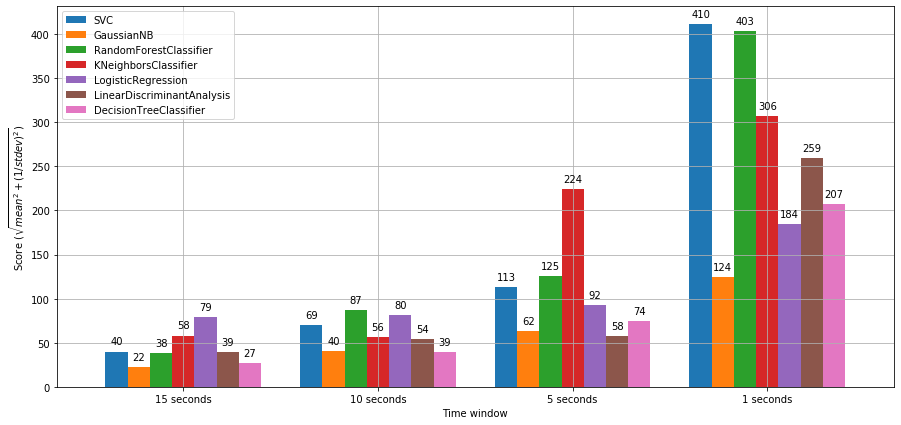

In [38]:
def plot_original_samples_classification(results):
    assert all(result.keys() == results[0].keys() for result in results)
    classifier_names = [key for key in results[0].keys()]
    classifier_scores = []
    
    get_score = lambda mean, std: np.sqrt((mean**2) + ((1/std)**2)) if std != 0 else std
    for name in classifier_names:
        score = [get_score(*result[name]) for result in results]
        classifier_scores.append(score)    
    
    data = pd.DataFrame({
        name: scores for name, scores in zip(classifier_names, classifier_scores)
    }, index=[f'{window} seconds' for window in TIME_WINDOWS])

    ax = data.plot.bar(figsize=(15, 7), width=.8)
    ax.set_xlabel('Time window')
    ax.set_ylabel(r'Score $(\sqrt{mean^2 + (1/stdev)^2})$')
    ax.grid()
    
    for p in ax.patches:
        ax.annotate(
            int(p.get_height()) if p.get_height() != 0 else '∞', 
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center', va='center',
            xytext=(0, 10), textcoords='offset points') 
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    
plot_original_samples_classification(results['original_samples_classification'])

### Utilizando SelectKBest

In [39]:
PERCENTAGES = (.1, .3, .5, .7)

In [40]:
def get_best_features_classification(values, k, lock):
    df_, n_seg = values
    
    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()

    # filtra as melhores características
    selector = sfs.SelectKBest(sfs.f_classif, k=k).fit(X, y)

    # retorna os índices das melhores características
    best_features_indices = selector.get_support(indices=True)

    # seleciona o nome das melhores colunas incluindo o outcome
    cols = np.append(df_.columns[best_features_indices], 'outcome')

    # filtra a tabela para apenas as colunas selecionadas
    df_ = df_.loc[:, cols]

    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()
    
    classifiers = (
        svm.SVC(gamma='auto', C=1),
        naive_bayes.GaussianNB(var_smoothing=1e-8),
        ensemble.RandomForestClassifier(n_estimators=50),
        sms.GridSearchCV(
            neighbors.KNeighborsClassifier(),
            {'n_neighbors': range(5, 11)}, cv=5, iid=False
        ),
        linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1),
        discriminant_analysis.LinearDiscriminantAnalysis(),
        tree.DecisionTreeClassifier(max_depth=6),
    )
    
    result = {}
    for classifier in classifiers:
        classifier.fit(X, y)
        
        name = classifier.__class__.__name__
        if name == 'GridSearchCV':
            name = classifier.best_estimator_.__class__.__name__
            
        accuracies = sms.cross_val_score(classifier, X, y, cv=ss)
        
        with lock:
            write_accuracies('best_features_classification', {
                'percentage': int((k / NUM_FEATURES) * 100),
                'n_seg': n_seg,
                'classifier': name,
                'accuracies': ','.join(f'{a}' for a in accuracies)
            })
        
        mean, std = accuracies.mean(), accuracies.std()
        result[name] = (mean, std)
        
    return result

In [41]:
%%time
m = multiprocessing.Manager()
lock = m.Lock()

bf_results = {}
for percent in PERCENTAGES:
    k = int(percent * NUM_FEATURES)
    function = functools.partial(get_best_features_classification, k=k, lock=lock)
    bf_results[percent] = apply_parallel(function, [(dfs[w], w) for w in TIME_WINDOWS])
    
results['best_features_classification'] = bf_results

CPU times: user 256 ms, sys: 213 ms, total: 470 ms
Wall time: 1h 26min 6s


In [42]:
def report_best_features_classification(results_):
    for percent, results in results_.items():
        print(f'Separando {int(percent*NUM_FEATURES)} características ({int(percent*100)}%):')
        
        for window, result in zip(TIME_WINDOWS, results):
            print(f'    Divisão de {window} segundos:')

            classifiers_with_scores = [(name, mean, std) for name, (mean, std) in result.items()]
            classifiers_with_scores.sort(reverse=True, key=lambda x: np.sqrt((x[1]**2) + ((1/x[2])**2)))
            for i, (name, mean, std) in enumerate(classifiers_with_scores, start=1):
                print(f'        {i}. {name} ─ {mean*100:.2f}% (+/- {std*100:.2f}%)')
            print()
            
        print()
    
report_best_features_classification(results['best_features_classification'])

Separando 27 características (10%):
    Divisão de 15 segundos:
        1. SVC ─ 94.74% (+/- 2.33%)
        2. LogisticRegression ─ 92.18% (+/- 2.46%)
        3. LinearDiscriminantAnalysis ─ 89.23% (+/- 3.10%)
        4. RandomForestClassifier ─ 95.51% (+/- 3.15%)
        5. KNeighborsClassifier ─ 93.33% (+/- 3.38%)
        6. GaussianNB ─ 91.03% (+/- 3.39%)
        7. DecisionTreeClassifier ─ 90.64% (+/- 4.10%)

    Divisão de 10 segundos:
        1. DecisionTreeClassifier ─ 90.43% (+/- 1.47%)
        2. KNeighborsClassifier ─ 95.98% (+/- 1.48%)
        3. SVC ─ 93.59% (+/- 1.92%)
        4. LogisticRegression ─ 92.05% (+/- 1.99%)
        5. RandomForestClassifier ─ 95.64% (+/- 2.00%)
        6. LinearDiscriminantAnalysis ─ 92.39% (+/- 2.11%)
        7. GaussianNB ─ 90.51% (+/- 2.92%)

    Divisão de 5 segundos:
        1. KNeighborsClassifier ─ 97.52% (+/- 0.68%)
        2. DecisionTreeClassifier ─ 92.61% (+/- 1.01%)
        3. RandomForestClassifier ─ 96.20% (+/- 1.26%)
        4. L

## Mistura de classificações

### Utilizando amostras originais

In [43]:
def get_original_samples_mixed_classification(values, lock):
    df_, n_seg = values
    
    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()
    
    classifiers = (
        svm.SVC(gamma='auto', C=1),
        naive_bayes.GaussianNB(var_smoothing=1e-8),
        ensemble.RandomForestClassifier(n_estimators=50),
        sms.GridSearchCV(
            neighbors.KNeighborsClassifier(),
            {'n_neighbors': range(5, 11)}, cv=5, iid=False
        ),
        linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1),
        discriminant_analysis.LinearDiscriminantAnalysis(),
        tree.DecisionTreeClassifier(max_depth=6),
    )
    
    vc = ensemble.VotingClassifier([(c.__class__.__name__, c) for c in classifiers]).fit(X, y)
    accuracies = sms.cross_val_score(vc, X, y, cv=ss)
    
    with lock:
        write_accuracies('original_samples_mixed_classification', {
            'n_seg': n_seg,
            'accuracies': ','.join(f'{a}' for a in accuracies)
        })
    
    return accuracies.mean(), accuracies.std()

In [44]:
%%time
m = multiprocessing.Manager()
lock = m.Lock()
function = functools.partial(get_original_samples_mixed_classification, lock=lock)
results['original_samples_mixed_classification'] = \
    apply_parallel(function, [(dfs[w], w) for w in TIME_WINDOWS])

/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/enzo/harddrive/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

CPU times: user 116 ms, sys: 82.8 ms, total: 198 ms
Wall time: 48min 57s


In [45]:
def report_original_samples_mixed_classification(results):
    for n_seg, (mean, std) in zip(TIME_WINDOWS, results):
        print(f'Divisão de {n_seg} segundos: {mean*100:.2f}% (+/- {std*100:.2f}%)')
    
report_original_samples_mixed_classification(results['original_samples_mixed_classification'])

Divisão de 15 segundos: 98.59% (+/- 1.76%)
Divisão de 10 segundos: 99.23% (+/- 0.60%)
Divisão de 5 segundos: 99.23% (+/- 0.71%)
Divisão de 1 segundos: 99.06% (+/- 0.26%)


### Utilizando SelectKBest

In [46]:
def get_best_features_mixed_classification(values, k, lock):
    df_, n_seg = values
    
    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()

    # filtra as melhores características
    selector = sfs.SelectKBest(sfs.f_classif, k=k).fit(X, y)

    # retorna os índices das melhores características
    best_features_indices = selector.get_support(indices=True)

    # seleciona o nome das melhores colunas incluindo o outcome
    cols = np.append(df_.columns[best_features_indices], 'outcome')

    # filtra a tabela para apenas as colunas selecionadas
    df_ = df_.loc[:, cols]

    X = df_.drop(['outcome'], axis=1).to_numpy()
    X = spp.StandardScaler().fit_transform(X)
    y = df_['outcome'].to_numpy()
    
    classifiers = (
        svm.SVC(gamma='auto', C=1),
        naive_bayes.GaussianNB(var_smoothing=1e-8),
        ensemble.RandomForestClassifier(n_estimators=50),
        sms.GridSearchCV(
            neighbors.KNeighborsClassifier(),
            {'n_neighbors': range(5, 11)}, cv=5, iid=False
        ),
        linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=1),
        discriminant_analysis.LinearDiscriminantAnalysis(),
        tree.DecisionTreeClassifier(max_depth=6),
    )
    
    vc = ensemble.VotingClassifier([(c.__class__.__name__, c) for c in classifiers]).fit(X, y)
    accuracies = sms.cross_val_score(vc, X, y, cv=ss)
    
    with lock:
        write_accuracies('best_features_mixed_classification', {
            'percentage': int((k / NUM_FEATURES) * 100),
            'n_seg': n_seg,
            'accuracies': ','.join(f'{a}' for a in accuracies)
        })
    
    return accuracies.mean(), accuracies.std()

In [47]:
%%time
m = multiprocessing.Manager()
lock = m.Lock()

bf_results = {}
for percent in PERCENTAGES:
    k = int(percent * NUM_FEATURES)
    function = functools.partial(get_best_features_mixed_classification, k=k, lock=lock)
    bf_results[percent] = apply_parallel(function, [(dfs[w], w) for w in TIME_WINDOWS])
    
results['best_features_mixed_classification'] = bf_results

CPU times: user 244 ms, sys: 185 ms, total: 429 ms
Wall time: 1h 34s


In [48]:
def report_best_features_mixed_classification(results_):
    for percent, results in results_.items():
        print(f'Separando {int(percent*NUM_FEATURES)} características ({int(percent*100)}%):')
        
        for n_seg, (mean, std) in zip(TIME_WINDOWS, results):
            print(f'    Divisão de {n_seg} segundos: {mean*100:.2f}% (+/- {std*100:.2f}%)')
            
        print()
    
report_best_features_mixed_classification(results['best_features_mixed_classification'])

Separando 27 características (10%):
    Divisão de 15 segundos: 94.87% (+/- 1.99%)
    Divisão de 10 segundos: 93.85% (+/- 1.83%)
    Divisão de 5 segundos: 93.93% (+/- 1.77%)
    Divisão de 1 segundos: 94.02% (+/- 0.66%)

Separando 81 características (30%):
    Divisão de 15 segundos: 95.90% (+/- 1.70%)
    Divisão de 10 segundos: 96.75% (+/- 1.52%)
    Divisão de 5 segundos: 97.61% (+/- 0.88%)
    Divisão de 1 segundos: 96.45% (+/- 0.61%)

Separando 136 características (50%):
    Divisão de 15 segundos: 96.92% (+/- 1.83%)
    Divisão de 10 segundos: 98.29% (+/- 0.54%)
    Divisão de 5 segundos: 98.59% (+/- 0.96%)
    Divisão de 1 segundos: 98.00% (+/- 0.37%)

Separando 191 características (70%):
    Divisão de 15 segundos: 98.72% (+/- 1.40%)
    Divisão de 10 segundos: 99.23% (+/- 0.97%)
    Divisão de 5 segundos: 99.44% (+/- 0.43%)
    Divisão de 1 segundos: 98.89% (+/- 0.20%)

